# Intercomparison Campaigns - Aggregated Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns, especially aggregated data. 

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [1]:
import pandas
import numpy as np
import datetime
import glob
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

## Fetching data and checking it for consitency

We open the whole aggregated dataset to check for errors.

Aggregated datasets contains mean values of intercomparison campagne data and variables related to the process of building mean values:

    data.reference_sonde_type:
    the reference for the difference values
    
    data.sample_size:
    describes the number of single datasets which go into the meanvalue of the observed_variable
    
    data.sample_error:
    describes the data's standard error

Those parameters are added automaticaly, whenever a station_id of aggregated data is requested.

In [3]:
# creating a list of files to open - selcting every aggregated file:
filestoopen = glob.glob('/raid60/scratch/leo/scratch/RI/Pangaea/nc/0-20200*.nc', recursive=True)
for i in range(len(filestoopen)):
    filestoopen[i] = filestoopen[i][42:-3]
print(filestoopen)

['0-20200-0-01501', '0-20200-0-01502', '0-20200-0-01201', '0-20200-0-00401', '0-20200-0-00402', '0-20200-0-00403', '0-20200-0-00404', '0-20200-0-00405', '0-20200-0-00406', '0-20200-0-00407', '0-20200-0-00408', '0-20200-0-00409', '0-20200-0-00410', '0-20200-0-00411', '0-20200-0-00412', '0-20200-0-00413', '0-20200-0-00414', '0-20200-0-00415', '0-20200-0-00416', '0-20200-0-00417', '0-20200-0-00418', '0-20200-0-00419', '0-20200-0-00420', '0-20200-0-00421', '0-20200-0-00422', '0-20200-0-00423', '0-20200-0-00424', '0-20200-0-00425', '0-20200-0-00426', '0-20200-0-00427', '0-20200-0-00428', '0-20200-0-01401', '0-20200-0-00901', '0-20200-0-00902', '0-20200-0-00903', '0-20200-0-00904', '0-20200-0-00905', '0-20200-0-00906', '0-20200-0-00907', '0-20200-0-00908', '0-20200-0-00909', '0-20200-0-00910', '0-20200-0-00911', '0-20200-0-00912', '0-20200-0-00913', '0-20200-0-00914', '0-20200-0-00915', '0-20200-0-00916', '0-20200-0-00917', '0-20200-0-00918', '0-20200-0-00919', '0-20200-0-00920', '0-20200-0-

In [4]:
# requesting and downloading the data:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature", 'air_relative_humidity'],
                   'statid': filestoopen,
                   'optional': ['sonde_type'],
                   'format': 'csv'                   
               })

if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    # Unzip the Data Stream
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/2")
    print(z.namelist())
    z.extractall(path='./example_data/2')
    z.close()
    os.remove('download.zip')
    print("Time elapsed: ", time.time()-t0, "s")

/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2020-10-01 08:53:23,911 INFO Welcome to the CDS
2020-10-01 08:53:23,912 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2020-10-01 08:53:24,042 INFO Request is completed
2020-10-01 08:53:24,043 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1

Unzipping retrieved files: to ./exampla_data/2
['temperature.csv', 'relative_humidity.csv']
Time elapsed:  0.33828306198120117 s


In [5]:
pandas.set_option('display.width',200, 'display.max_rows',50)
data = pandas.read_csv('example_data/2/temperature.csv', index_col=0)
data_hum = pandas.read_csv('example_data/2/relative_humidity.csv', index_col=0)

In [6]:
data

,lat,lon,plev,sample_error,sample_size,ta,time,reference_sonde_type,sonde_type,trajectory_label,statid,statindex
obs_id,,,,,,,,,,,,
0,51.112747,-0.184474,1000.0,0.35,18.0,-0.11,1987-05-01 12:00:00,GK3,VHN,0-20200-0-01502-1,0-20200-0-01502,0
1,51.112747,-0.184474,1500.0,0.22,18.0,-0.25,1987-05-01 12:00:00,GK3,VHN,0-20200-0-01502-1,0-20200-0-01502,0
2,51.112747,-0.184474,2000.0,0.17,18.0,-0.31,1987-05-01 12:00:00,GK3,VHN,0-20200-0-01502-1,0-20200-0-01502,0
3,51.112747,-0.184474,3000.0,0.13,19.0,-0.07,1987-05-01 12:00:00,GK3,VHN,0-20200-0-01502-1,0-20200-0-01502,0
4,51.112747,-0.184474,5000.0,0.09,22.0,0.07,1987-05-01 12:00:00,GK3,VHN,0-20200-0-01502-1,0-20200-0-01502,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,59.930000,30.270000,40.0,0.63,NaN,0.02,1968-01-01 00:00:00,RKT,V16,0-20200-0-00504-2,0-20200-0-00504,81
2015,59.930000,30.270000,80.0,0.64,NaN,0.03,1968-01-01 00:00:00,RKT,V16,0-20200-0-00504-2,0-20200-0-00504,81
2016,59.930000,30.270000,160.0,0.66,NaN,0.22,1968-01-01 00:00:00,RKT,V16,0-20200-0-00504-2,0-20200-0-00504,81


In [7]:
data_hum

,hur,lat,lon,plev,sample_error,sample_size,time,reference_sonde_type,sonde_type,trajectory_label,statid,statindex
obs_id,,,,,,,,,,,,
0,NaN,53.900,27.570,10.0,NaN,8.0,1984-01-01 00:00:00,VHN,RR_,0-20200-0-01201-1,0-20200-0-01201,0
1,NaN,53.900,27.570,30.0,NaN,8.0,1984-01-01 00:00:00,VHN,RR_,0-20200-0-01201-1,0-20200-0-01201,0
2,NaN,53.900,27.570,50.0,NaN,8.0,1984-01-01 00:00:00,VHN,RR_,0-20200-0-01201-1,0-20200-0-01201,0
3,NaN,53.900,27.570,100.0,NaN,8.0,1984-01-01 00:00:00,VHN,RR_,0-20200-0-01201-1,0-20200-0-01201,0
4,NaN,53.900,27.570,200.0,NaN,8.0,1984-01-01 00:00:00,VHN,RR_,0-20200-0-01201-1,0-20200-0-01201,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1558,19.22,62.675,5.275,40000.0,10.92,NaN,1984-01-01 00:00:00,V2N,RK2,0-20200-0-01001-1,0-20200-0-01001,56
1559,13.44,62.675,5.275,50000.0,12.54,NaN,1984-01-01 00:00:00,V2N,RK2,0-20200-0-01001-1,0-20200-0-01001,56
1560,9.85,62.675,5.275,70000.0,8.97,NaN,1984-01-01 00:00:00,V2N,RK2,0-20200-0-01001-1,0-20200-0-01001,56


In [8]:
# we have data for these days:
data.time.drop_duplicates()

obs_id
0       1987-05-01 12:00:00
18      1987-05-01 00:00:00
72      1956-05-27 12:00:00
81      1956-05-27 00:00:00
108     1984-01-01 00:00:00
333     1985-01-01 00:00:00
339     1985-01-01 12:00:00
345     1981-04-20 12:00:00
359     1981-04-20 00:00:00
1885    1968-01-01 12:00:00
1893    1968-01-01 00:00:00
Name: time, dtype: object

## Selecting Data Correctly:

We now have to select the right data to plot it and check for errors.

Iterating over each day will give us data of one comparison campagne.
In every day dataset, there are mean values of each sonde type. Those haven been processed to the differences between every sensor and a chosen reference sonde.
We iterate over each of those reference sondes to get every possible comparison. 
 

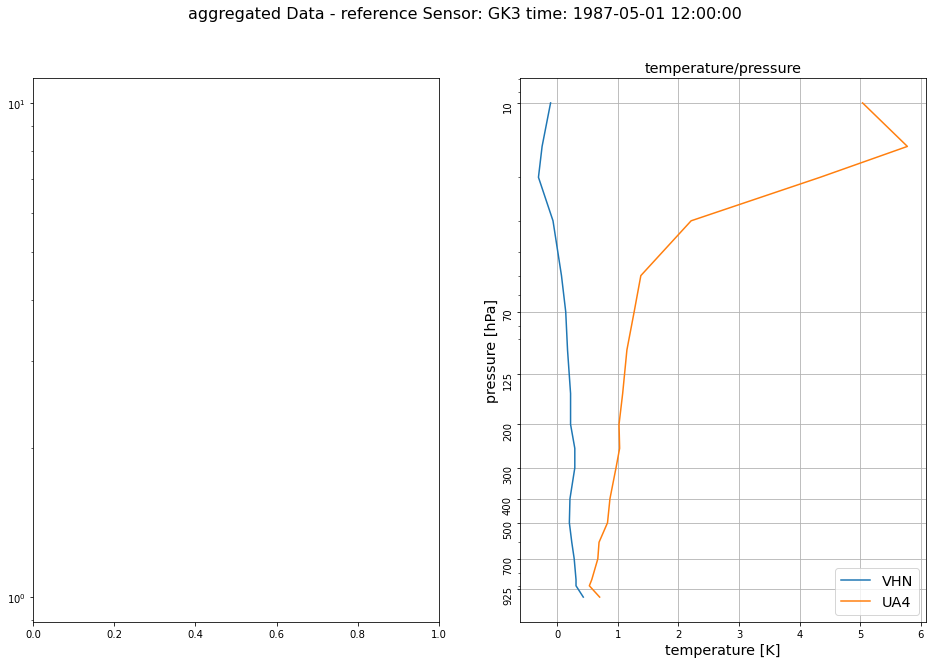

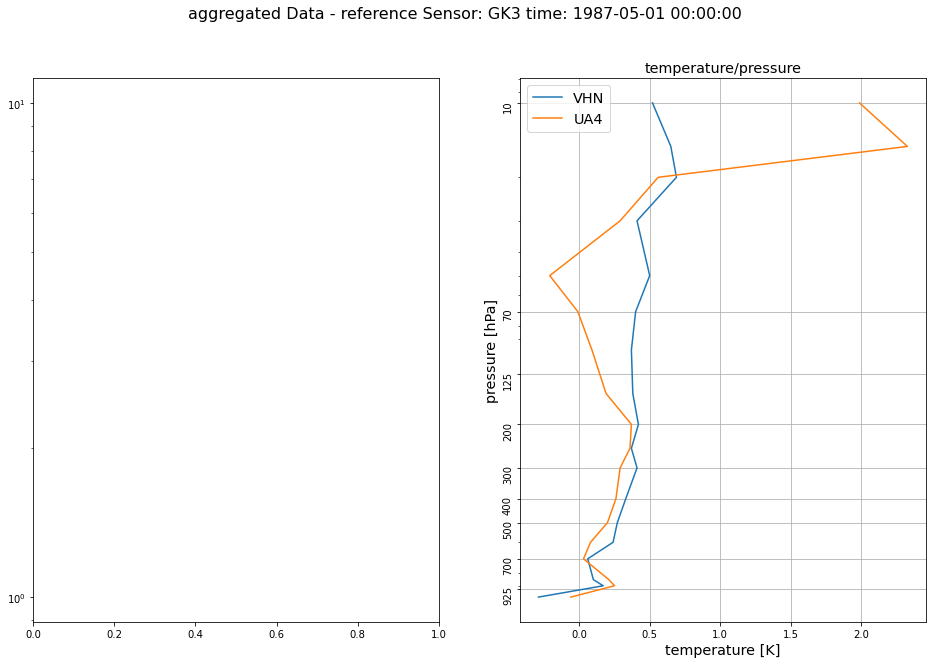

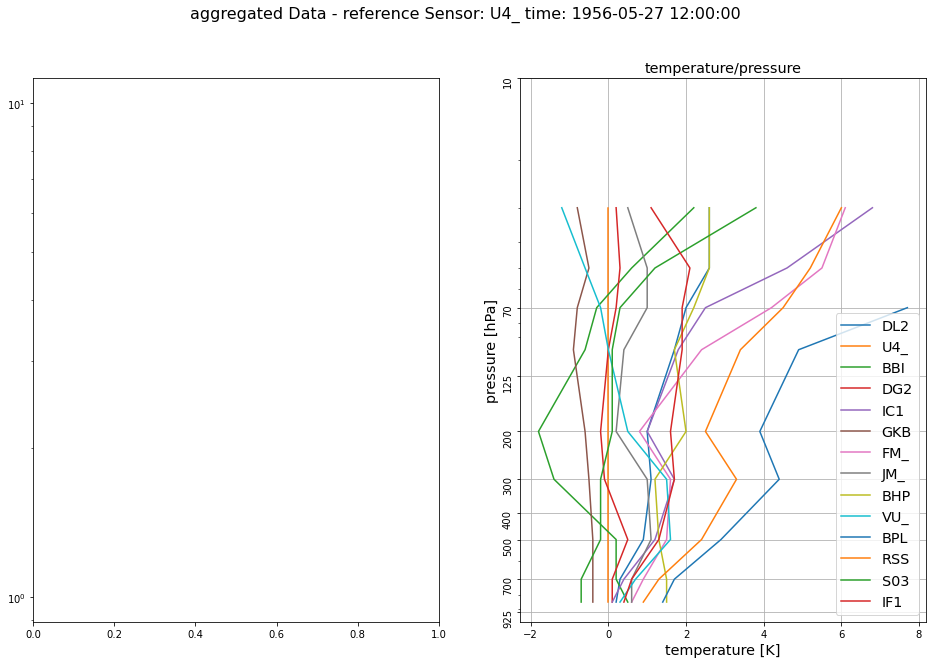

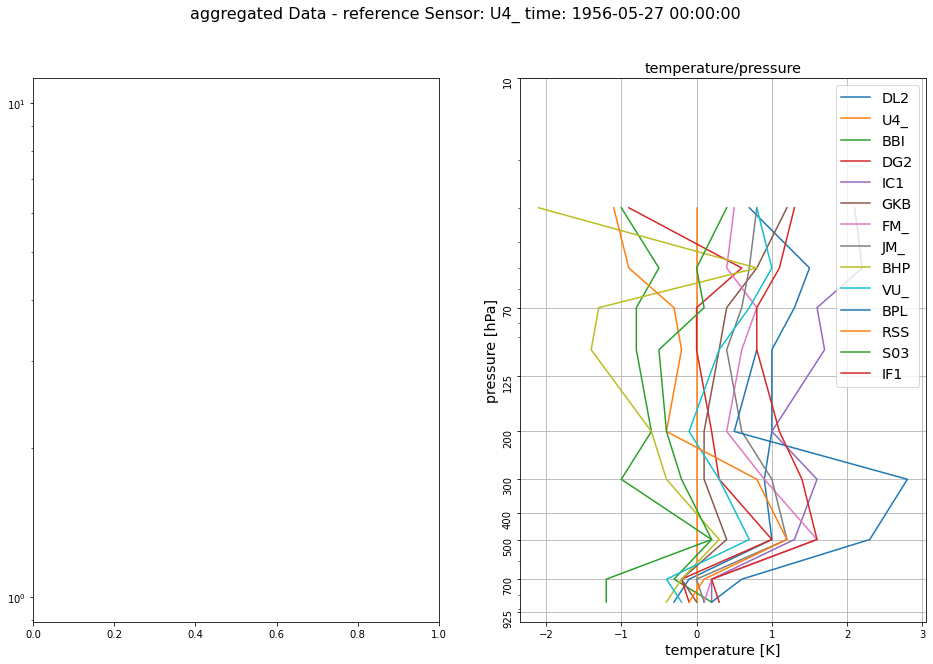

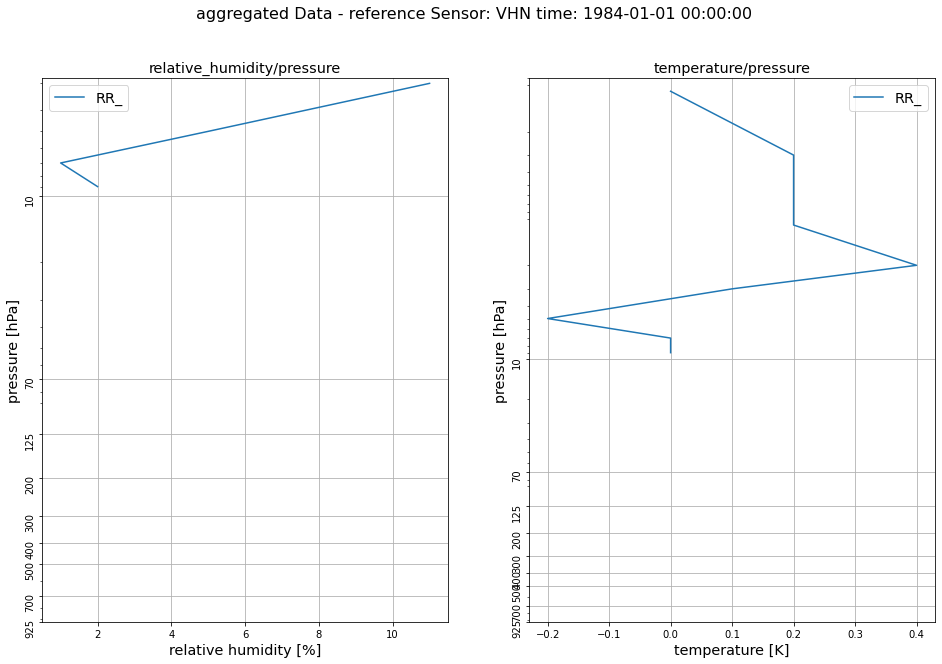

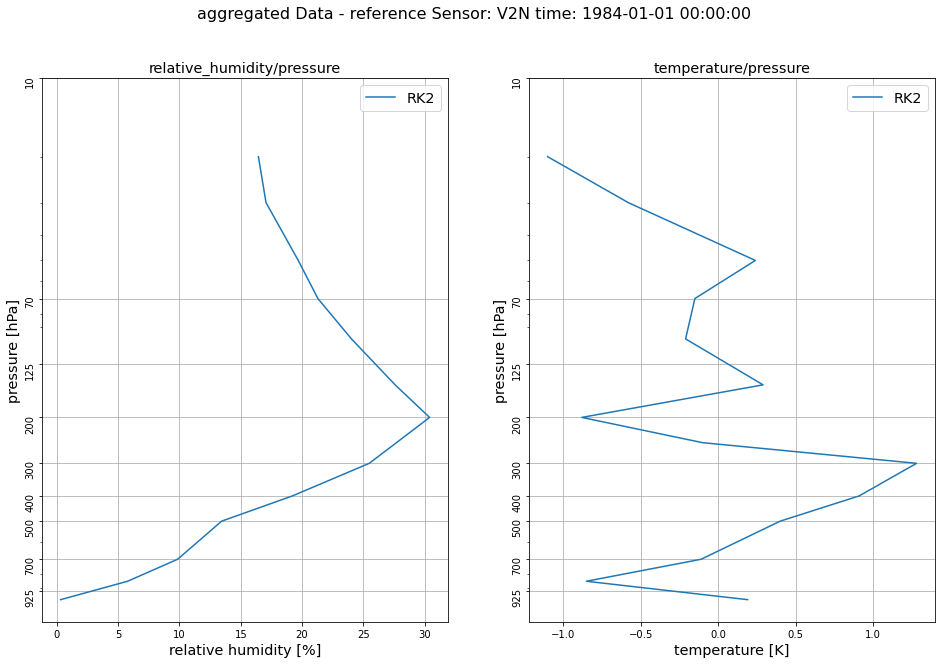

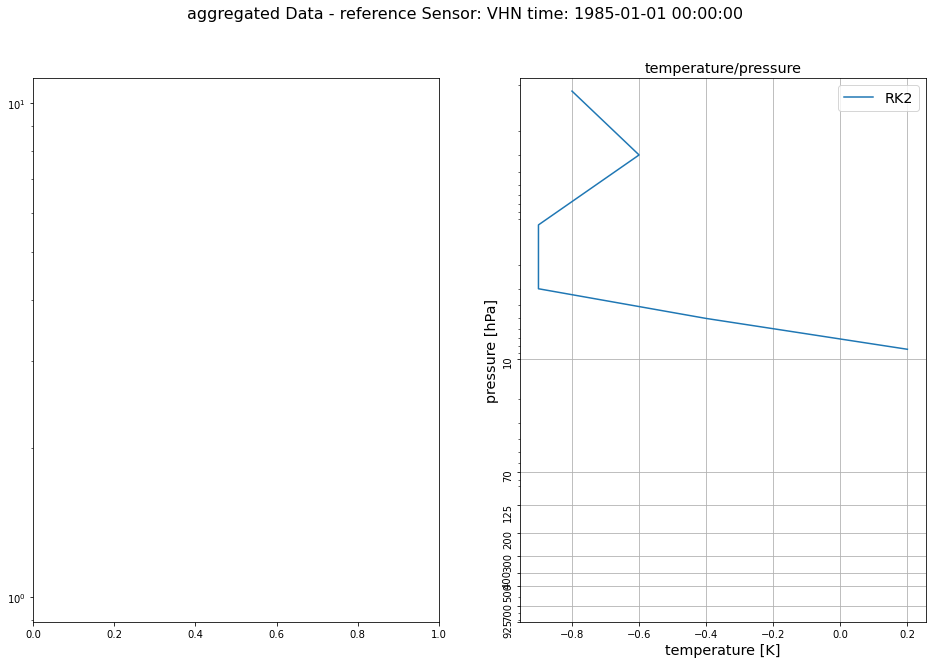

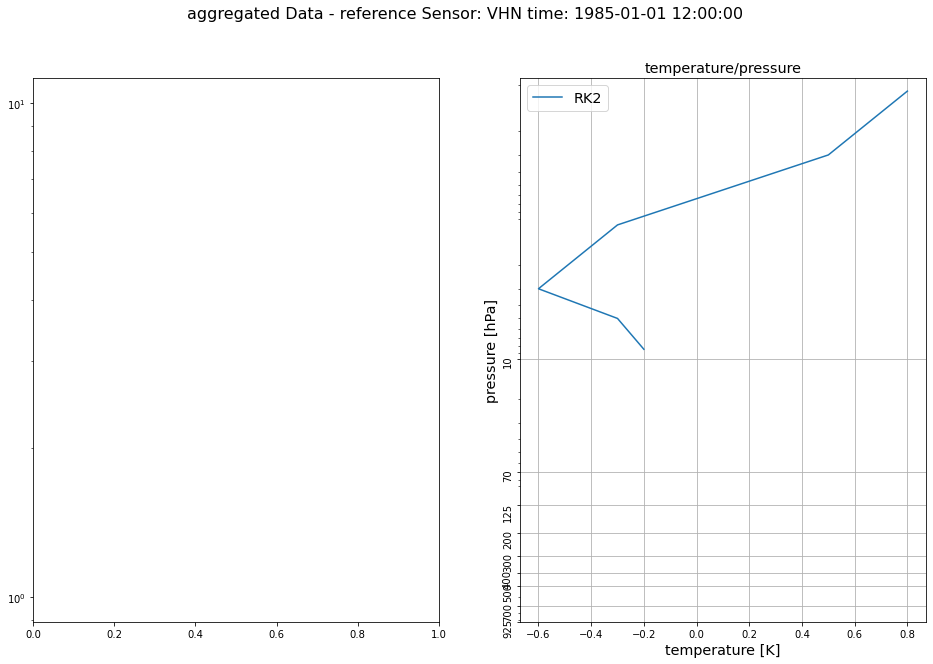

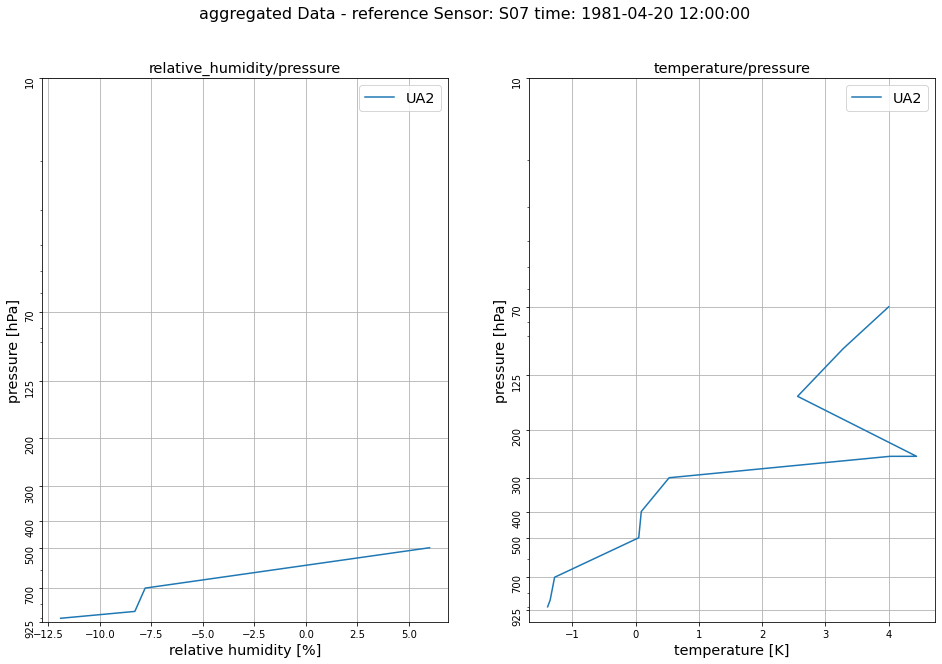

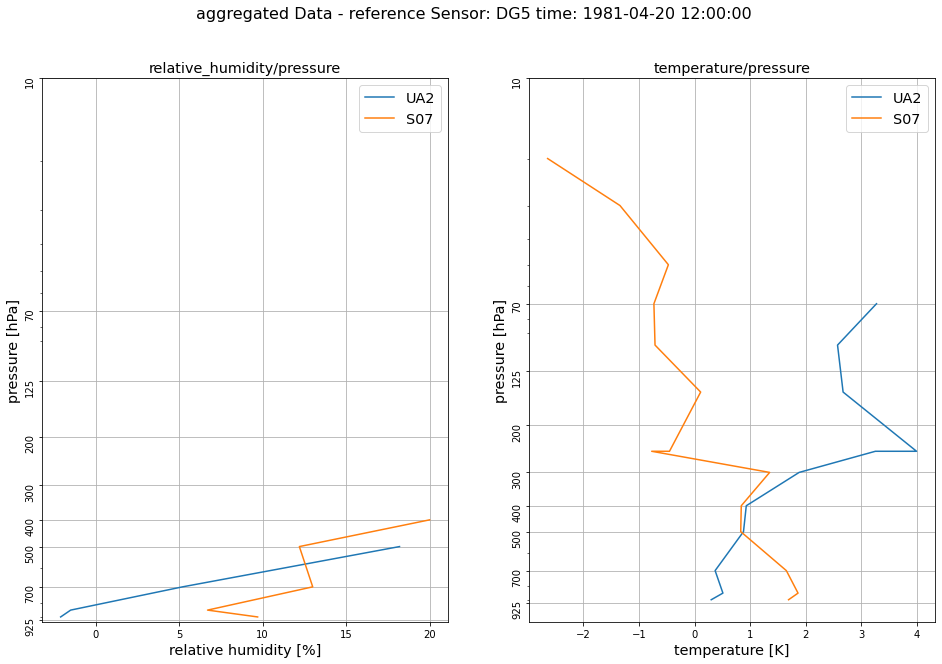

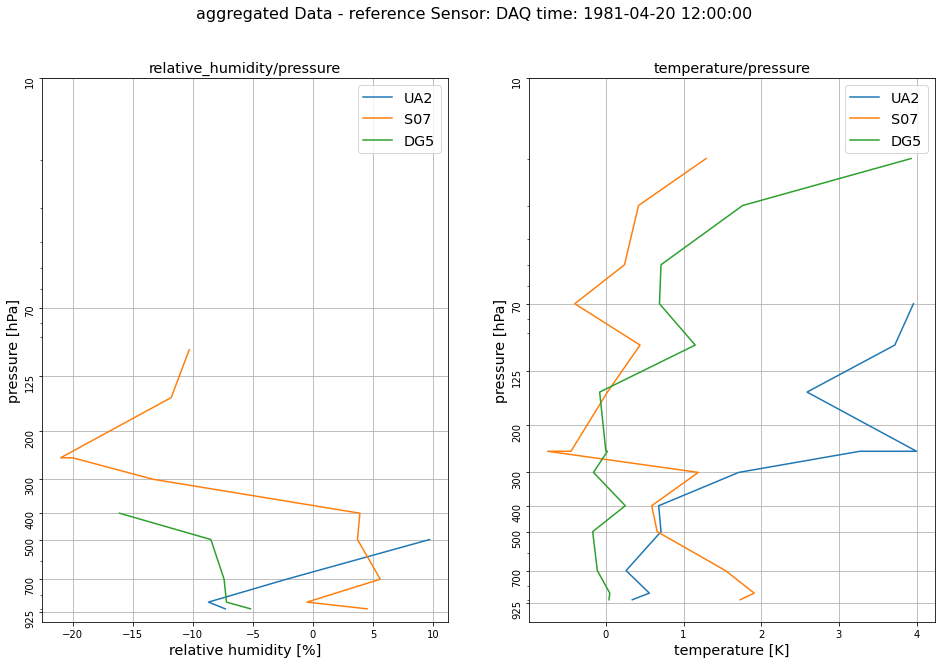

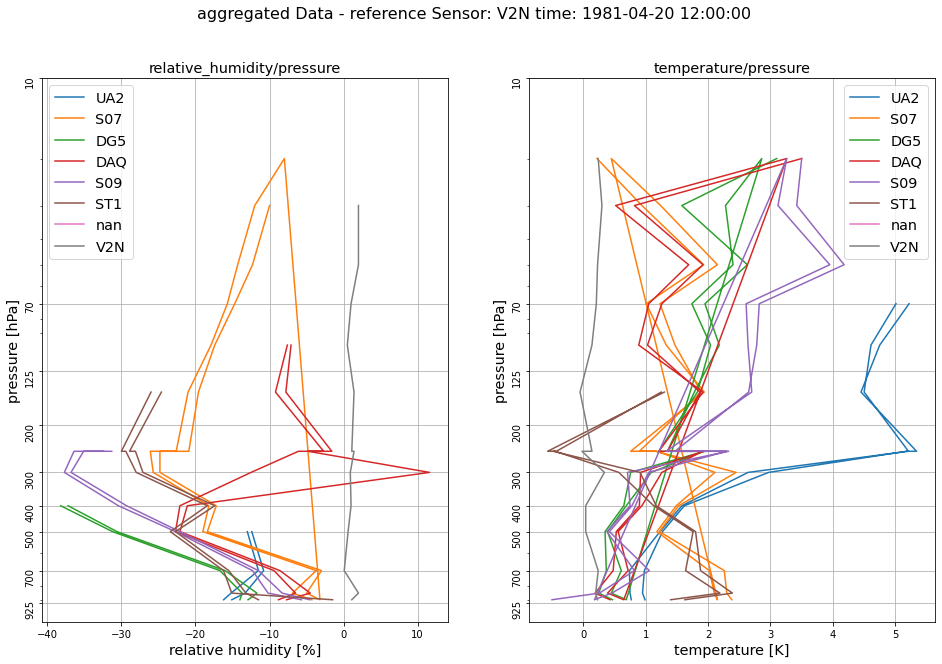

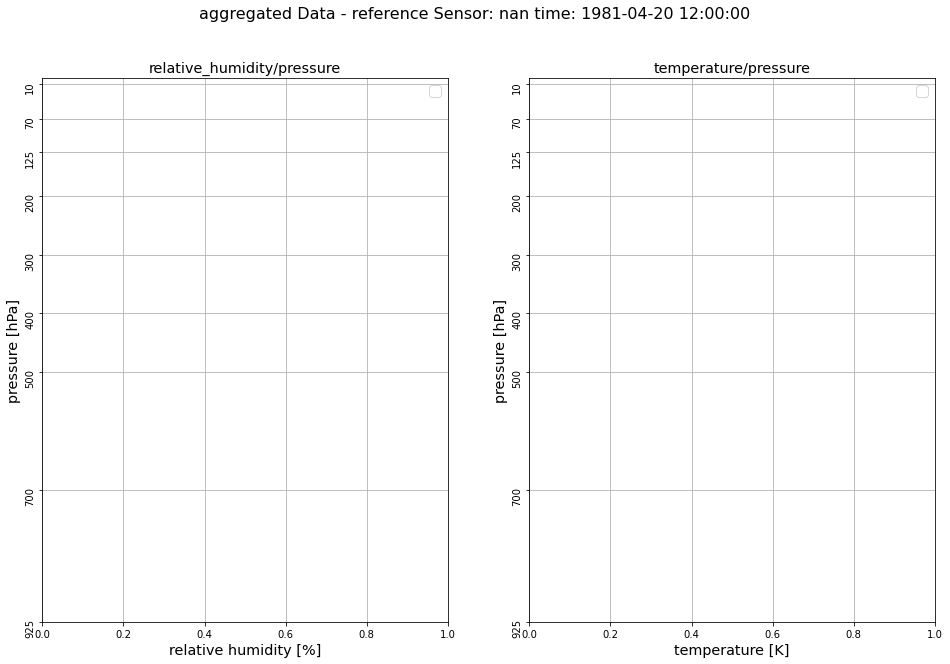

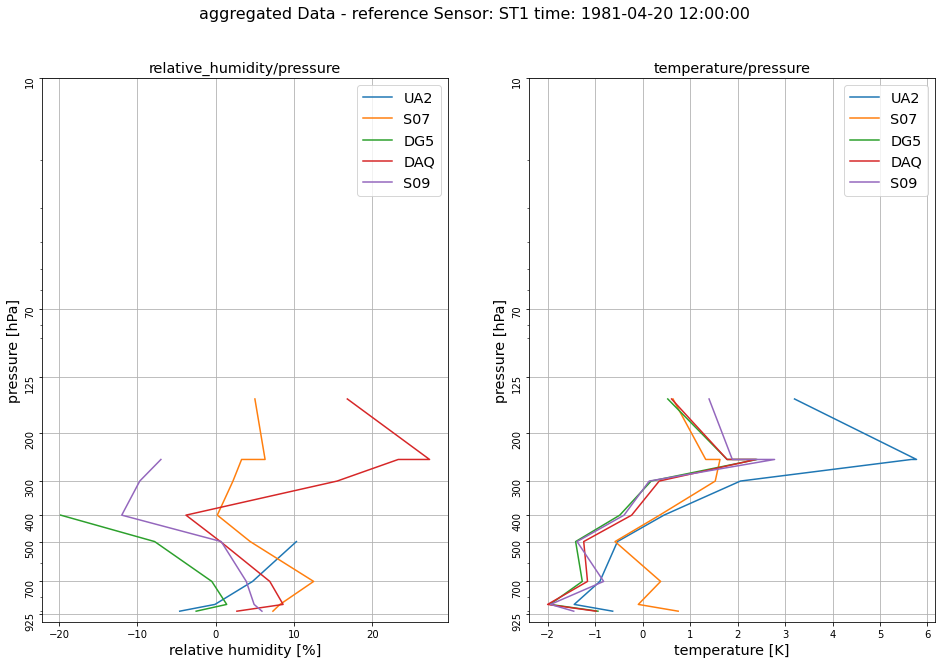

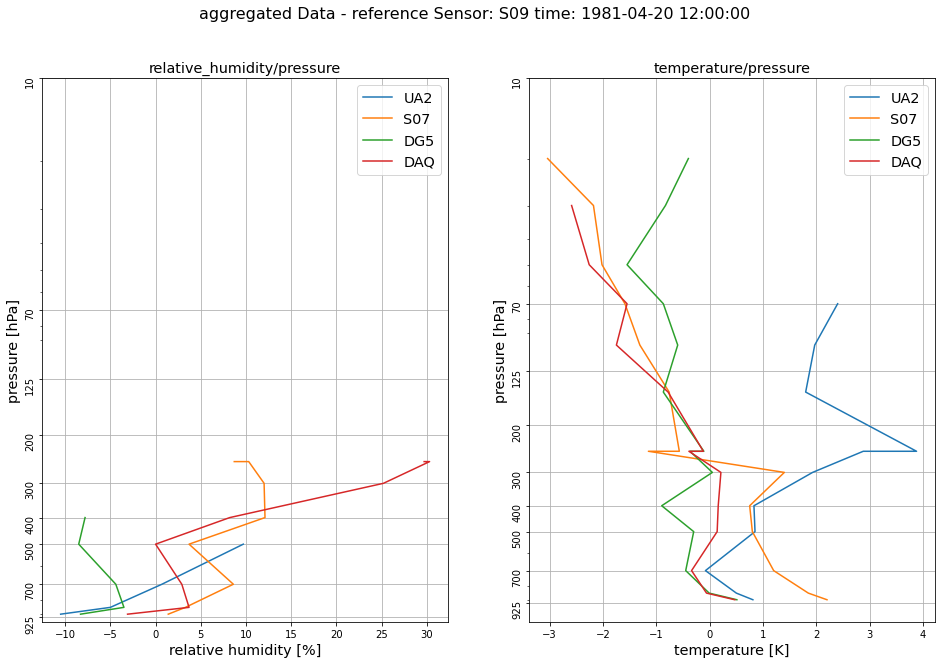

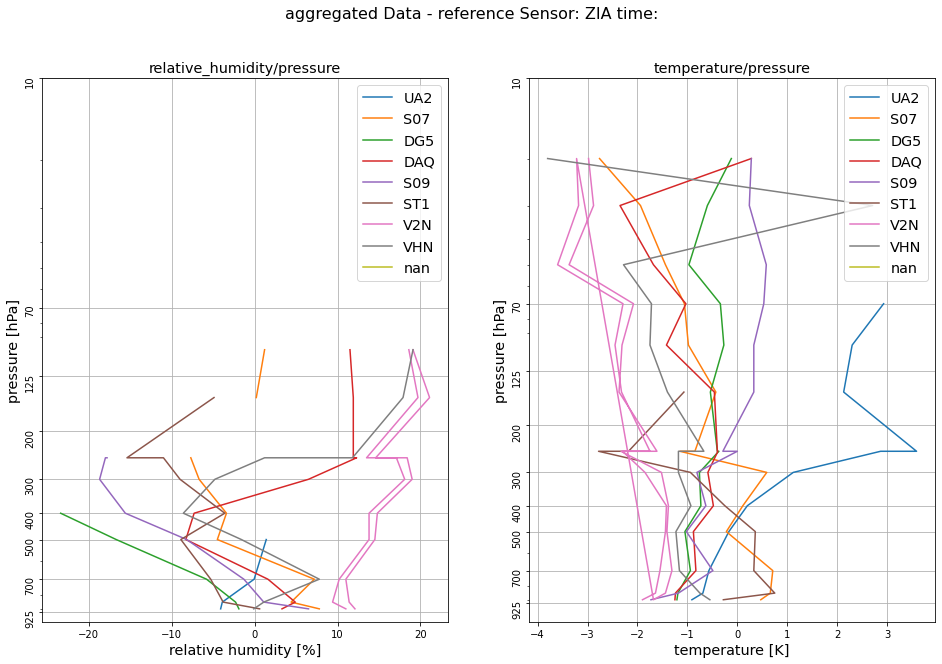

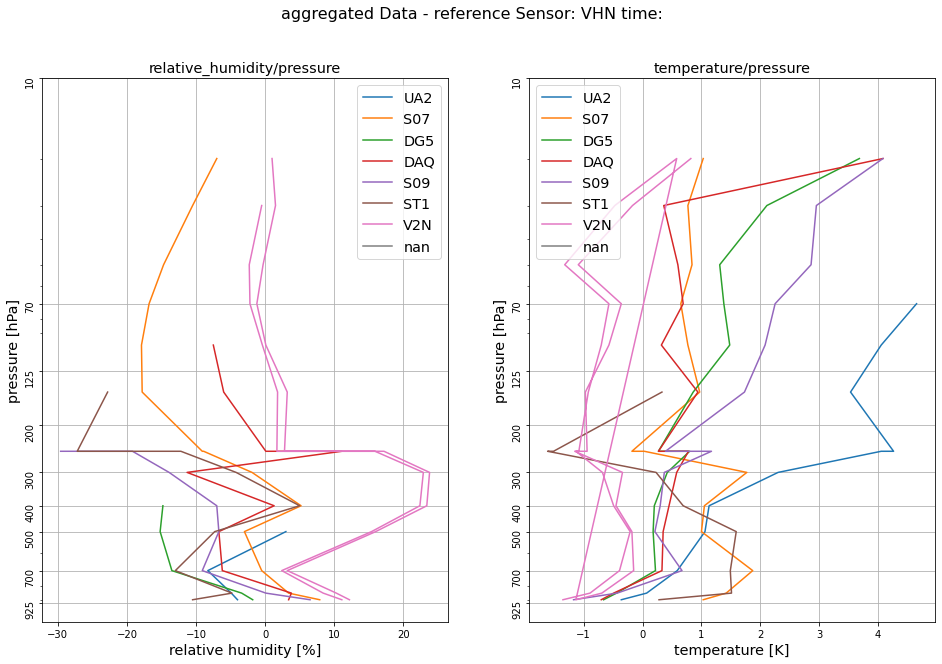

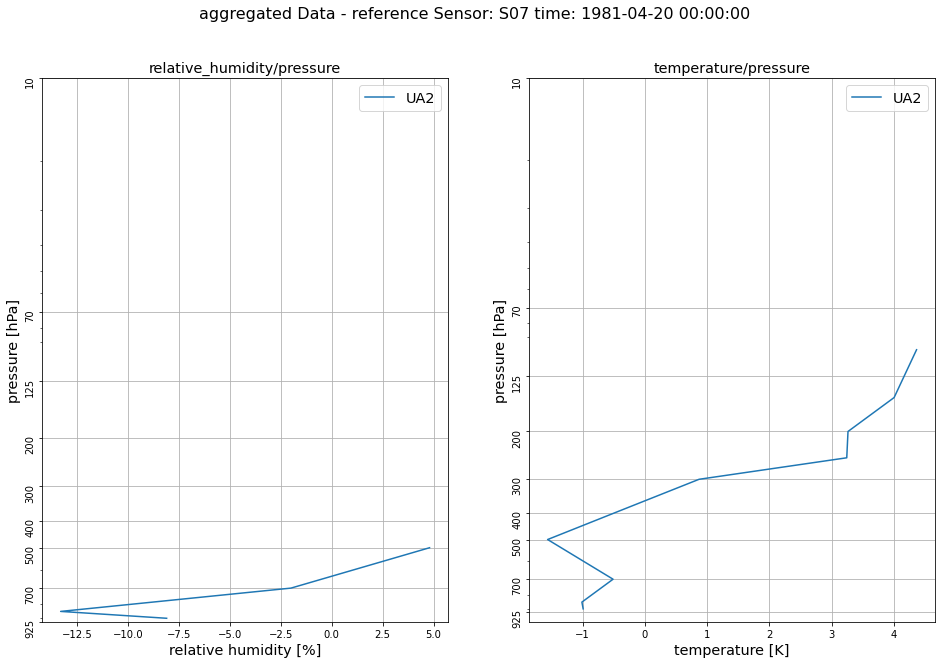

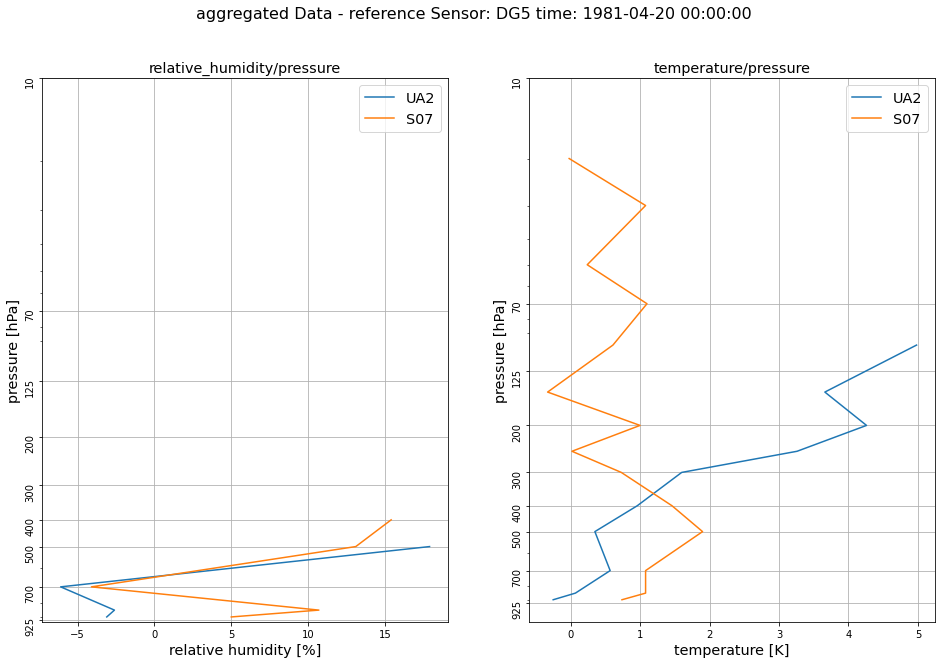

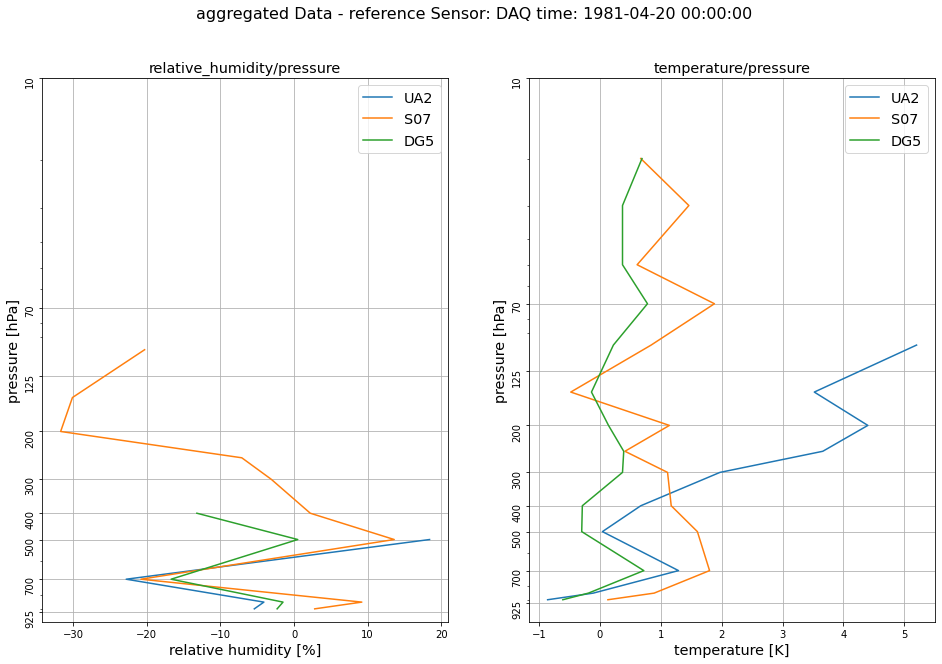

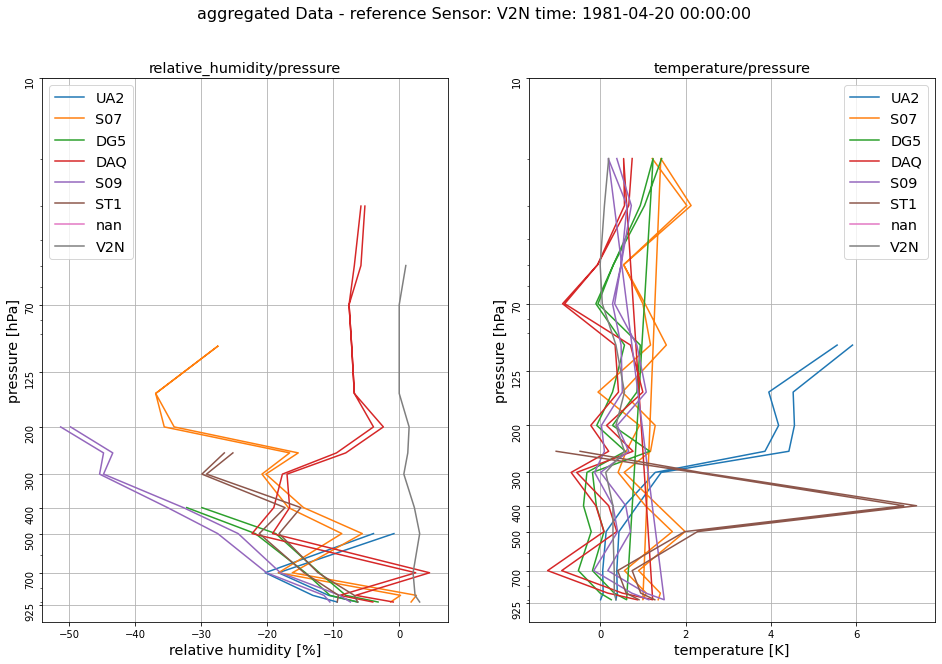

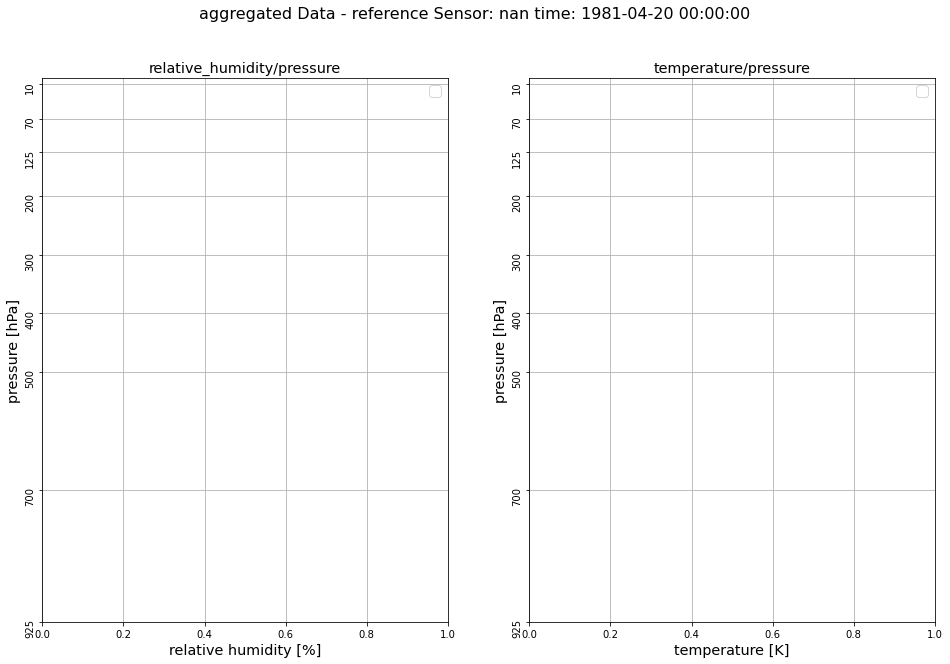

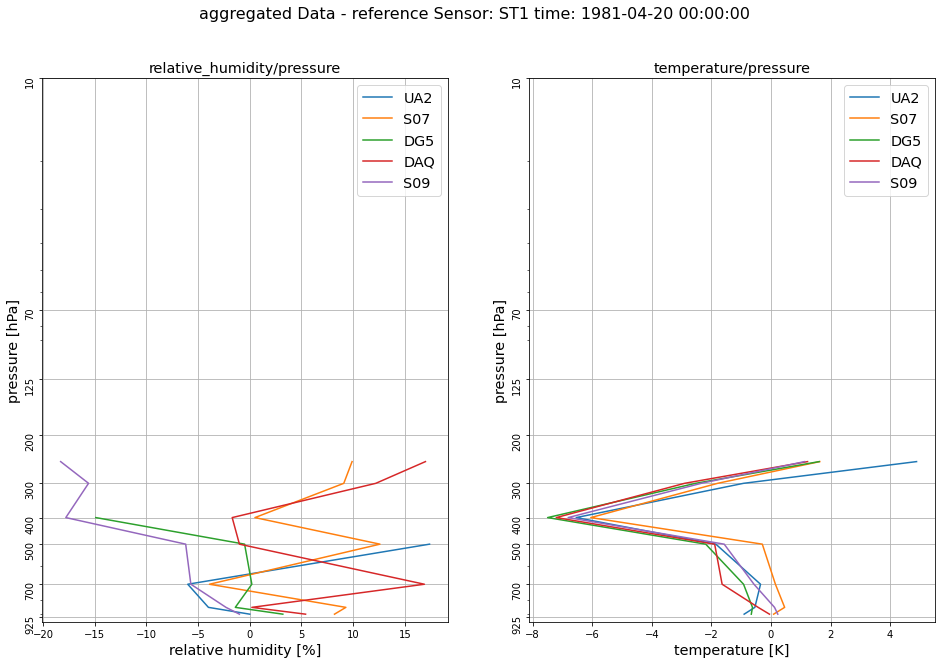

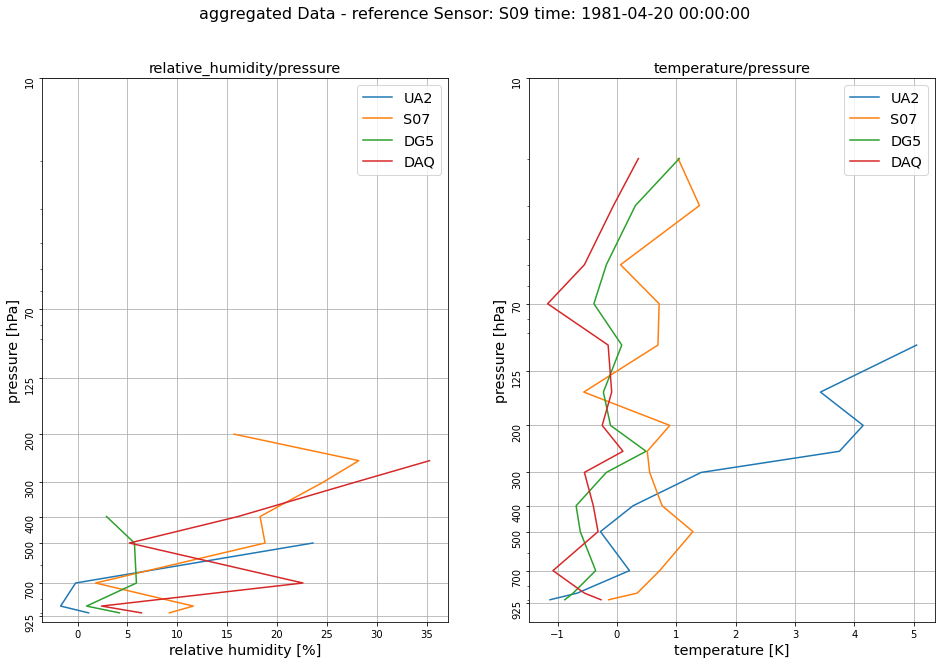

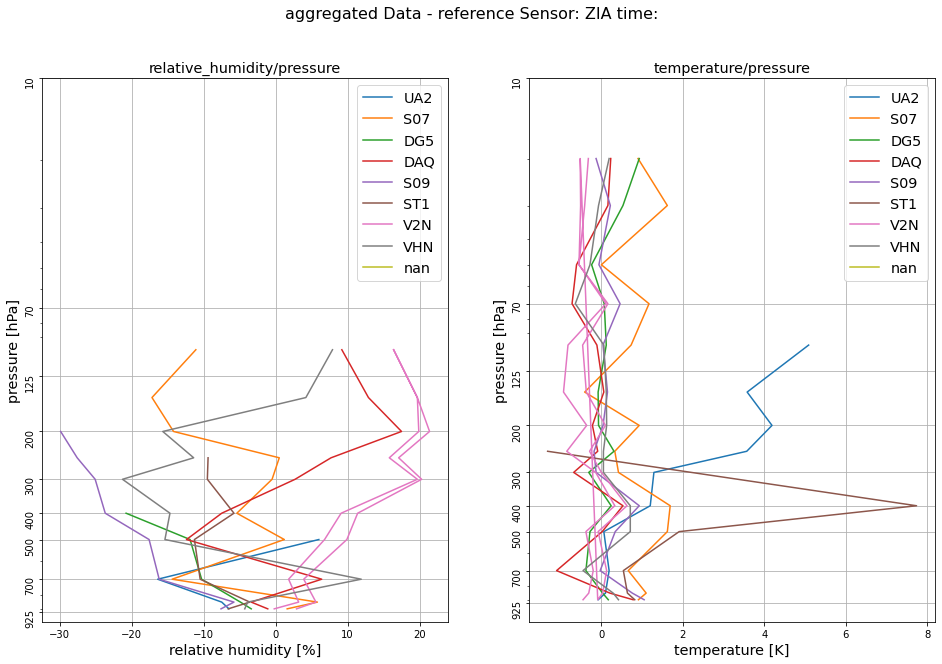

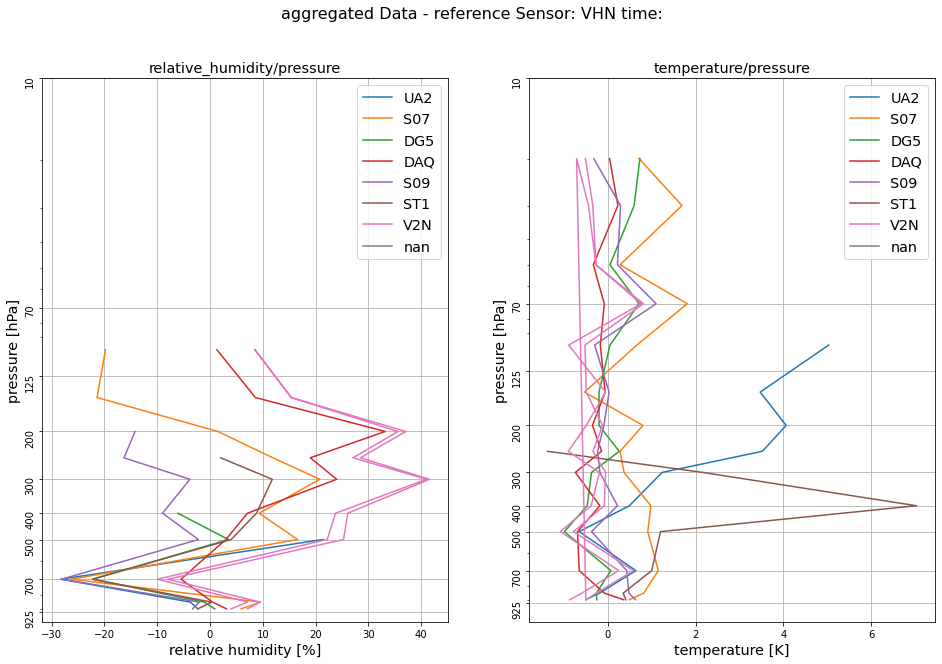

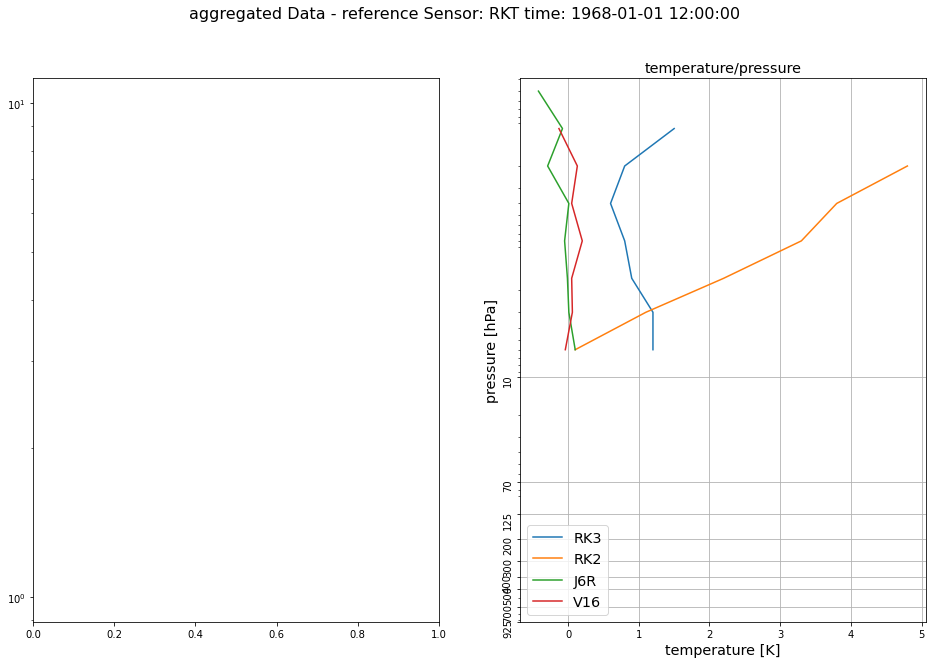

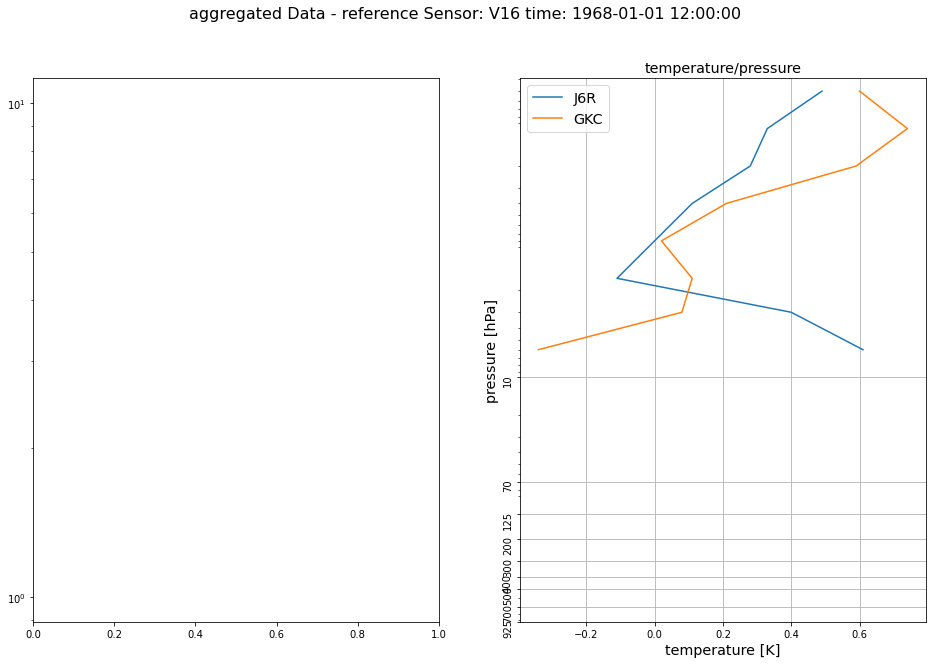

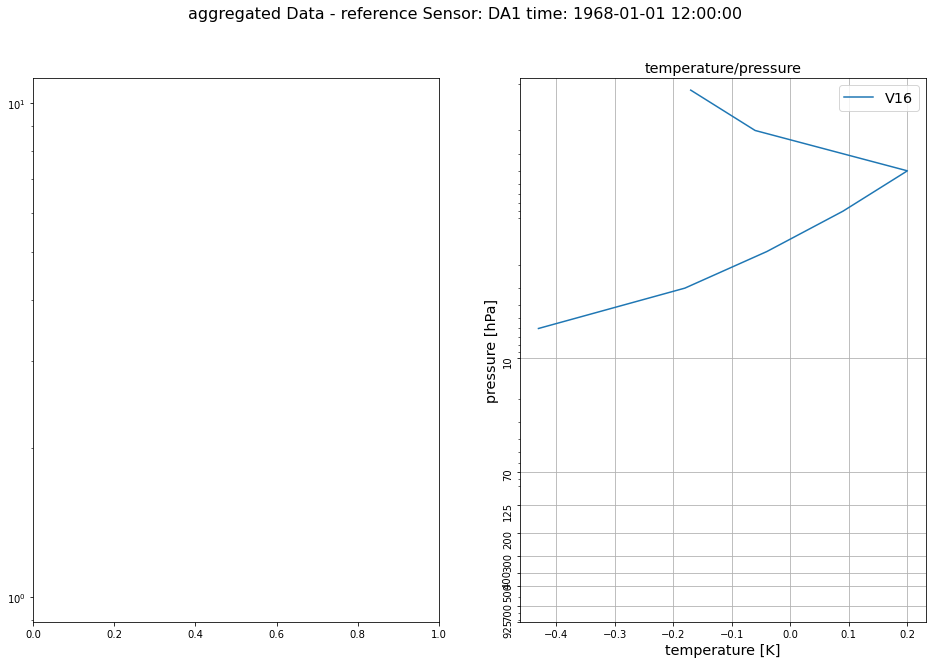

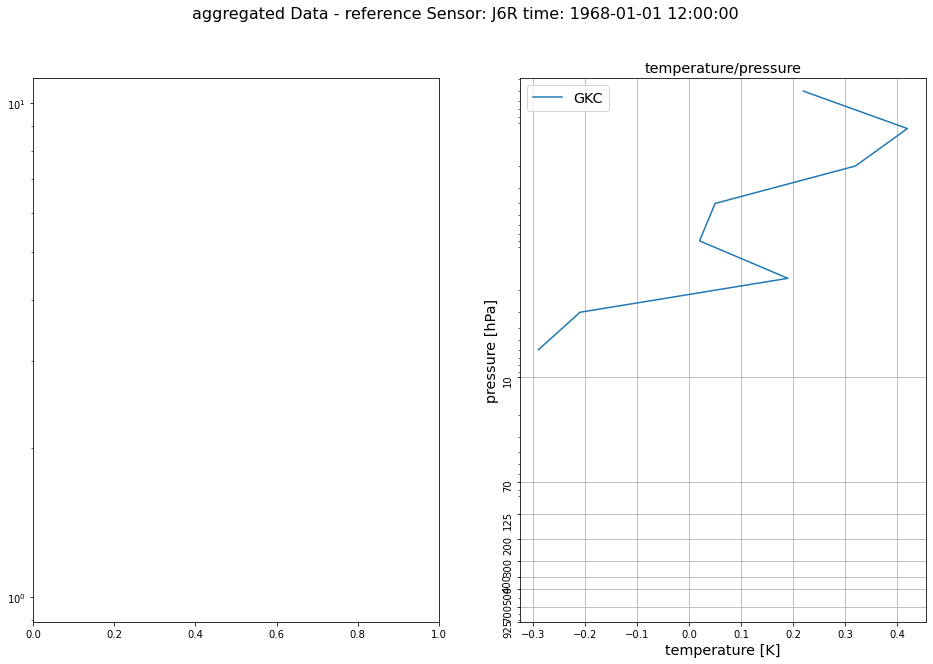

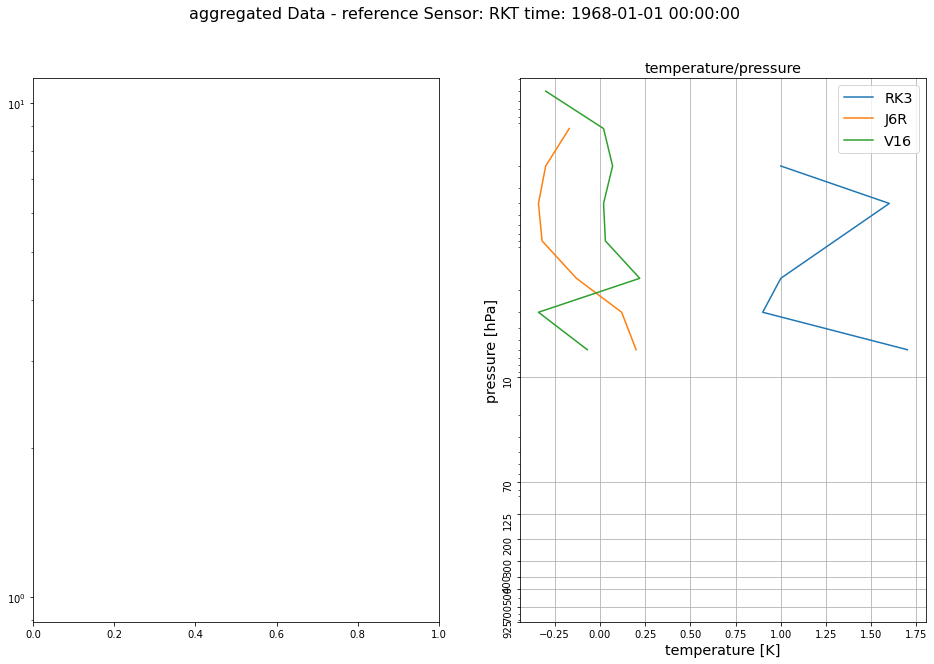

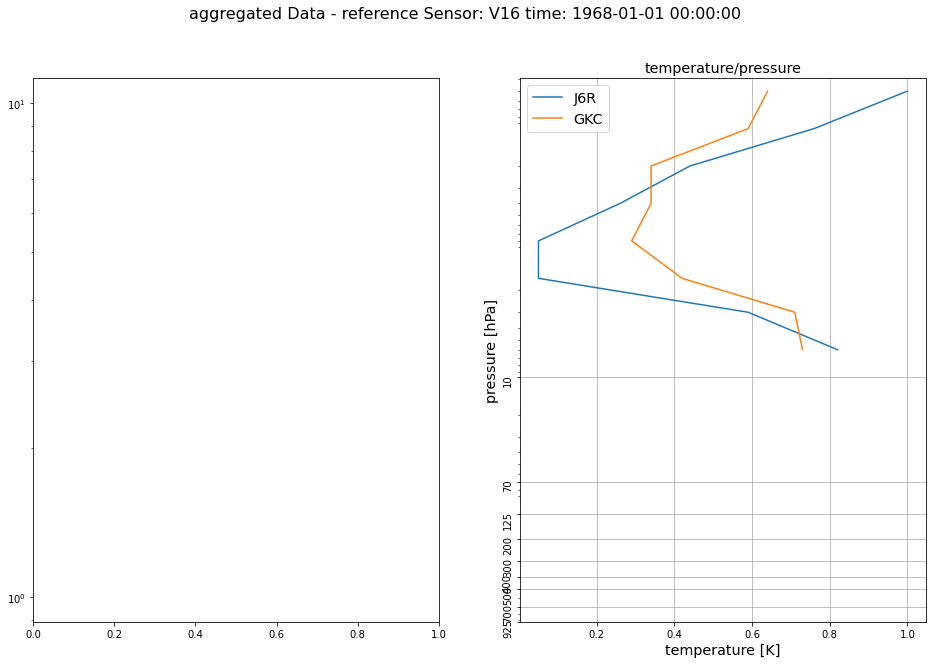

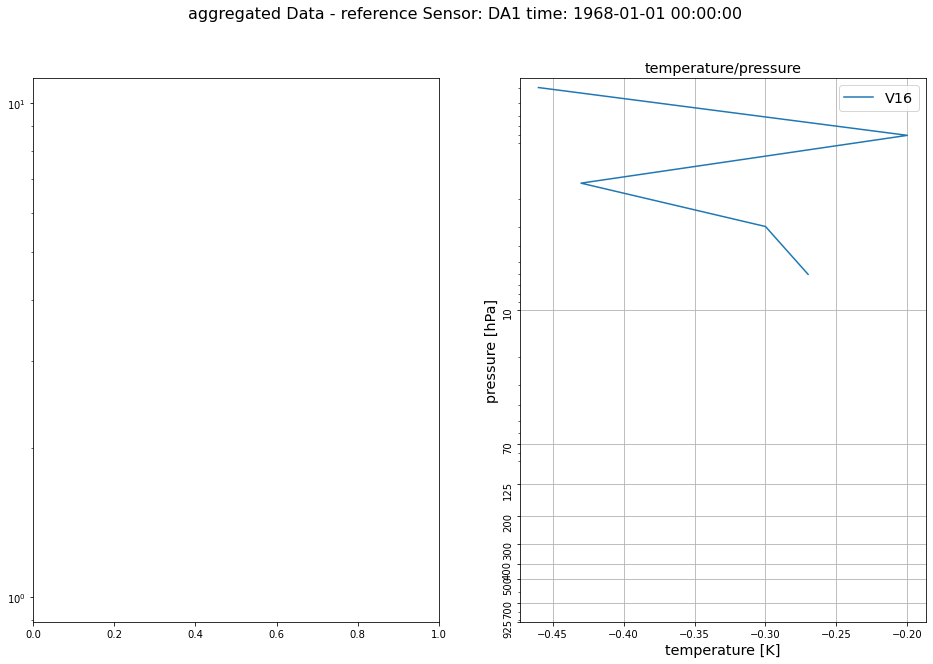

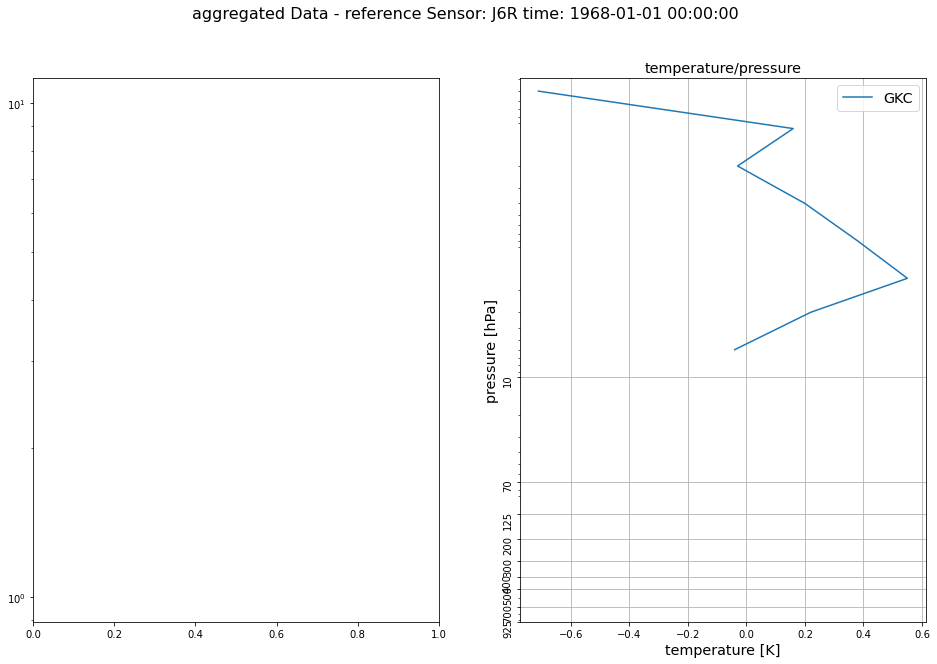

In [9]:
da = data
hu = data_hum
for i in da.time.drop_duplicates():
    a = da[da.time == i]
    c = hu[hu.time == i]
    for n in a.reference_sonde_type.drop_duplicates():
        b = a[a.reference_sonde_type == n]
        b = b.reset_index(drop=True)
        d = c[c.reference_sonde_type == n]
        d = d.reset_index(drop=True)
        
        pres = []
        humi = []
        temp = []
        #
        # get data of each available sonde:
        #
        for j in b.sonde_type.drop_duplicates():
            buffer = b[b.sonde_type == j]
            humib = d[d.sonde_type == j]
            pres.append(buffer.plev)
            temp.append(buffer.ta)
            humi.append(humib.hur)

        yplevs = np.array([10,70,125,200,300,400,500,700,925])*100.
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Plotting pressure over temperature: reference
        #
        try:
            for i in range(len(humi)):
                ax1.semilogy(np.array(humi[i]), np.array(pres[i]))
            ax1.set(xlabel ='relative humidity [%]', ylabel='pressure [hPa]', title='relative_humidity/pressure')
            ax1.legend(d.sonde_type.drop_duplicates(), loc='best')
            ax1.set_yticks(ticks=yplevs)
            ax1.set_yticklabels(map("{:.0f}".format,yplevs/100),rotation='vertical')
            ax1.invert_yaxis()
            ax1.grid()
        except:
            pass
        #
        # Plotting pressure over temperature: original
        #
        for i in range(len(temp)):
            ax2.semilogy(np.array(temp[i]), np.array(pres[i]))
        ax2.set(xlabel ='temperature [K]', ylabel='pressure [hPa]', title='temperature/pressure')
        ax2.legend(b.sonde_type.drop_duplicates(), loc='best')
        ax2.set_yticks(ticks=yplevs)
        ax2.set_yticklabels(map("{:.0f}".format,yplevs/100),rotation='vertical')
        ax2.invert_yaxis()
        ax2.grid()
        #     -
        fig.suptitle('aggregated Data - reference Sensor: '+ str(n) + ' time: ' + str(str(buffer.time.drop_duplicates().values)[2:21]), fontsize=16)
        plt.show()
        plt.close(fig)
        #

    